In [8]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Step 1: Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Step 2: Define the model creation function for GridSearch
def create_model(optimizer=Adam(), learn_rate=0.01):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    if optimizer == 'Adam':
        optimizer = Adam(learning_rate=learn_rate)
    elif optimizer == 'SGD':
        optimizer = SGD(learning_rate=learn_rate)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Step 3 and 5: Grid search for the best hyperparameters
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=32, verbose=0)
optimizer = ['SGD', 'Adam']
learn_rate = [0.001, 0.01]
param_grid = dict(optimizer=optimizer, learn_rate=learn_rate, batch_size=[32, 64])
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Step 6: Use callbacks and retrain the best model
best_optimizer = grid_result.best_params_['optimizer']
best_learn_rate = grid_result.best_params_['learn_rate']
best_batch_size = grid_result.best_params_['batch_size']

model = create_model(optimizer=best_optimizer, learn_rate=best_learn_rate)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=best_batch_size, callbacks=[reduce_lr], verbose=2)

# Evaluate the model
scores = model.evaluate(X_test, y_test, verbose=0)
print('Final CNN accuracy:', scores[1])

# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


ModuleNotFoundError: No module named 'keras.wrappers'

Epoch 1/100
2441/2441 - 8s - loss: 0.0126 - 8s/epoch - 3ms/step
Epoch 2/100
2441/2441 - 6s - loss: 0.0102 - 6s/epoch - 2ms/step
Epoch 3/100
2441/2441 - 6s - loss: 0.0100 - 6s/epoch - 3ms/step
Epoch 4/100
2441/2441 - 5s - loss: 0.0100 - 5s/epoch - 2ms/step
Epoch 5/100
2441/2441 - 5s - loss: 0.0100 - 5s/epoch - 2ms/step
Epoch 6/100
2441/2441 - 6s - loss: 0.0100 - 6s/epoch - 2ms/step
Epoch 7/100
2441/2441 - 5s - loss: 0.0099 - 5s/epoch - 2ms/step
Epoch 8/100
2441/2441 - 6s - loss: 0.0098 - 6s/epoch - 2ms/step
Epoch 9/100
2441/2441 - 5s - loss: 0.0099 - 5s/epoch - 2ms/step
Epoch 10/100
2441/2441 - 6s - loss: 0.0099 - 6s/epoch - 3ms/step
Epoch 11/100
2441/2441 - 5s - loss: 0.0099 - 5s/epoch - 2ms/step
Epoch 12/100
2441/2441 - 5s - loss: 0.0098 - 5s/epoch - 2ms/step
Epoch 13/100
2441/2441 - 5s - loss: 0.0097 - 5s/epoch - 2ms/step
Epoch 14/100
2441/2441 - 5s - loss: 0.0098 - 5s/epoch - 2ms/step
Epoch 15/100
2441/2441 - 6s - loss: 0.0097 - 6s/epoch - 2ms/step
Epoch 16/100
2441/2441 - 5s - loss

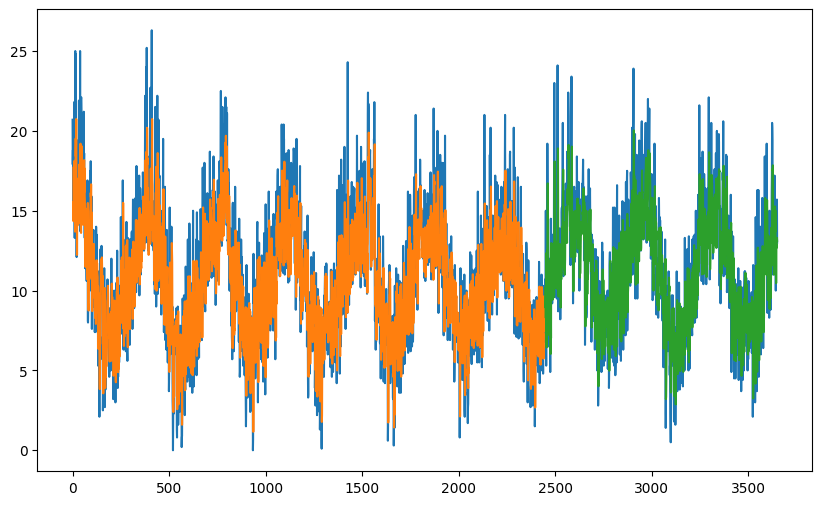

In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

# Step 1: Load the dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
dataframe = pd.read_csv(url, usecols=[1], engine='python')
dataset = dataframe.values.astype('float32')

# Step 2: Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Step 3: Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Step 4: Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Step 5: Evaluate the model
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate error scores
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print(f'Train Score: {trainScore:.2f} MAE')
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print(f'Test Score: {testScore:.2f} MAE')

# RMSE can be calculated similarly using mean_squared_error with squared=False

# Plotting baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(np.concatenate([np.empty((look_back+1))*np.nan, trainPredict[:,0]]))
plt.plot(np.concatenate([np.empty((len(train)+look_back+1))*np.nan, testPredict[:,0]]))
plt.show()